# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L2

import visualkeras
from PIL import ImageFont
from ann_visualizer.visualize import ann_viz


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loading with ImageDataGenerator

In [2]:
# Path to the directory containing the training images
train_dir = 'Train:Test/Train/'
test_dir = 'Train:Test/Test/'
print(os.listdir(train_dir))
print(os.listdir(test_dir))

['.DS_Store', 'VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']
['.DS_Store', 'VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']


In [3]:
image_size = (50, 50)
# Image dimensions

In [4]:
# Creating an instance of the ImageDataGenerator with data augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # Rescale pixel values between 0 and 1
#     horizontal_flip=True,     # Randomly flip images horizontally
#     rotation_range=20,         # Randomly rotate images by 20 degrees
#     vertical_flip=True,        # Randomly flip images vertically
#     Flips and rotations dont really help
    validation_split=0.2       # Split 20% of data for validation
)


# Creating an instance of the ImageDataGenerator for the Testing
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,         # Rescale pixel values between 0 and 1
)


In [5]:
# Generating training data from the images in the specified directory
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='training'# Use subset 'training' for training data
)

Found 19032 images belonging to 4 classes.


In [6]:
# Generating validation data from the images in the specified directory
validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
    subset='validation'        # Use subset 'validation' for validation data
)

Found 4757 images belonging to 4 classes.


In [7]:
# Generating Testing data from the images in the specified directory
testing_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='categorical',
     shuffle = False
)

Found 10195 images belonging to 4 classes.


# Build Model

In [8]:
model = Sequential()
model.add(Conv2D(64, (3,3), 1, activation = 'relu', input_shape =(50,50,3)))
model.add(Conv2D(64, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D(2,2))

# Adding a Dropout Layer
model.add(Dropout(0.2)) # dropout on previous activations

model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D(2,2))

# Adding a Dropout Layer
model.add(Dropout(0.4)) # dropout on previous activations

model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
model.add(Conv2D(256, (3,3), 1, activation = 'relu'))
model.add(Conv2D(128, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D(2,2))



model.add(Flatten())

# Adding a Dropout Layer
model.add(Dropout(0.1)) # dropout on previous activations

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))

Metal device set to: Apple M2 Pro


2023-07-20 18:24:20.435127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-20 18:24:20.435253: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
opt = Adam(learning_rate = 1e-3, beta_1 = 0.9, beta_2 = 0.999 ) # typical parameters

In [10]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy','AUC'] )

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 19, 19, 128)       147584    
                                                        

# Fit Model

In [12]:
#  will use validation loss: stopping to prevent overfitting.
trainCallback = EarlyStopping(monitor='loss', min_delta = 1e-6, patience = 5)
# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs/drop2-4',histogram_freq=1)

In [13]:
# Training the model
history_model = model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=[trainCallback]
)

Epoch 1/35


2023-07-20 18:24:20.660333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-20 18:24:20.981829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


594/595 [============================>.] - ETA: 0s - loss: 1.2411 - accuracy: 0.3773 - auc: 0.6709

2023-07-20 18:24:34.879867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


595/595 [==============================] - 16s 26ms/step - loss: 1.2407 - accuracy: 0.3776 - auc: 0.6712 - val_loss: 0.9168 - val_accuracy: 0.5655 - val_auc: 0.8426
Epoch 2/35
595/595 [==============================] - 15s 25ms/step - loss: 0.8773 - accuracy: 0.5781 - auc: 0.8510 - val_loss: 0.7653 - val_accuracy: 0.6428 - val_auc: 0.8893
Epoch 3/35
595/595 [==============================] - 15s 25ms/step - loss: 0.7803 - accuracy: 0.6266 - auc: 0.8816 - val_loss: 0.6903 - val_accuracy: 0.6845 - val_auc: 0.9121
Epoch 4/35
595/595 [==============================] - 15s 25ms/step - loss: 0.7095 - accuracy: 0.6689 - auc: 0.9040 - val_loss: 0.6013 - val_accuracy: 0.7259 - val_auc: 0.9315
Epoch 5/35
595/595 [==============================] - 15s 26ms/step - loss: 0.6464 - accuracy: 0.7039 - auc: 0.9214 - val_loss: 0.5809 - val_accuracy: 0.7463 - val_auc: 0.9392
Epoch 6/35
595/595 [==============================] - 15s 26ms/step - loss: 0.5880 - accuracy: 0.7345 - auc: 0.9352 - val_loss: 0.5

# Evaluate Model

In [14]:
# Model evaluation
model.evaluate(testing_generator)

319/319 [==============================] - 5s 16ms/step - loss: 0.1939 - accuracy: 0.9341 - auc: 0.9923


[0.19389981031417847, 0.9340853095054626, 0.9922690987586975]

In [15]:
# Model prediction
y_true = testing_generator.classes
y_pred_probs = model.predict(testing_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

 12/319 [>.............................] - ETA: 3s

2023-07-20 18:37:20.225184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


319/319 [==============================] - 4s 11ms/step


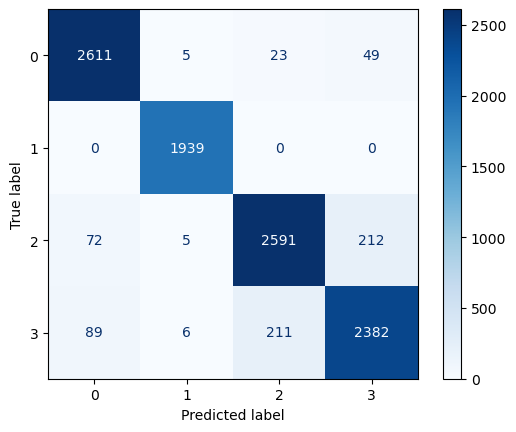

In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
plt.show()

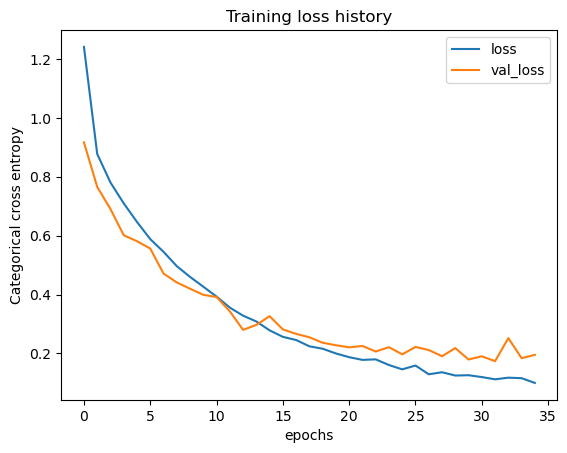

In [17]:
train_history_model = pd.DataFrame(history_model.history)
train_history_model.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_history_model[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

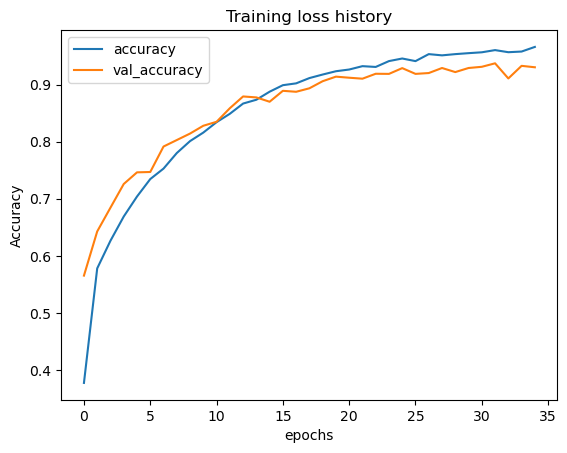

In [18]:
col_list = ['accuracy', 'val_accuracy']
train_history_model[col_list].plot()
plt.ylabel('Accuracy')
plt.title('Training loss history')
plt.show()

# Visualize the Model Architecture

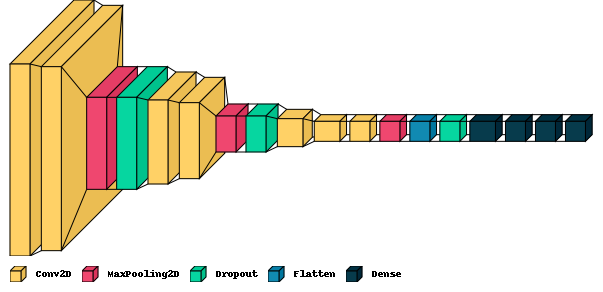

In [19]:
visualkeras.layered_view(model, legend=True)

In [20]:
# ann_viz(model, view=True, filename="Modelv2", title="CNN Model v2")

# Evaluation Using TensorBoard

## Comparing Different Accuracy per Epoch of Validation Testing 

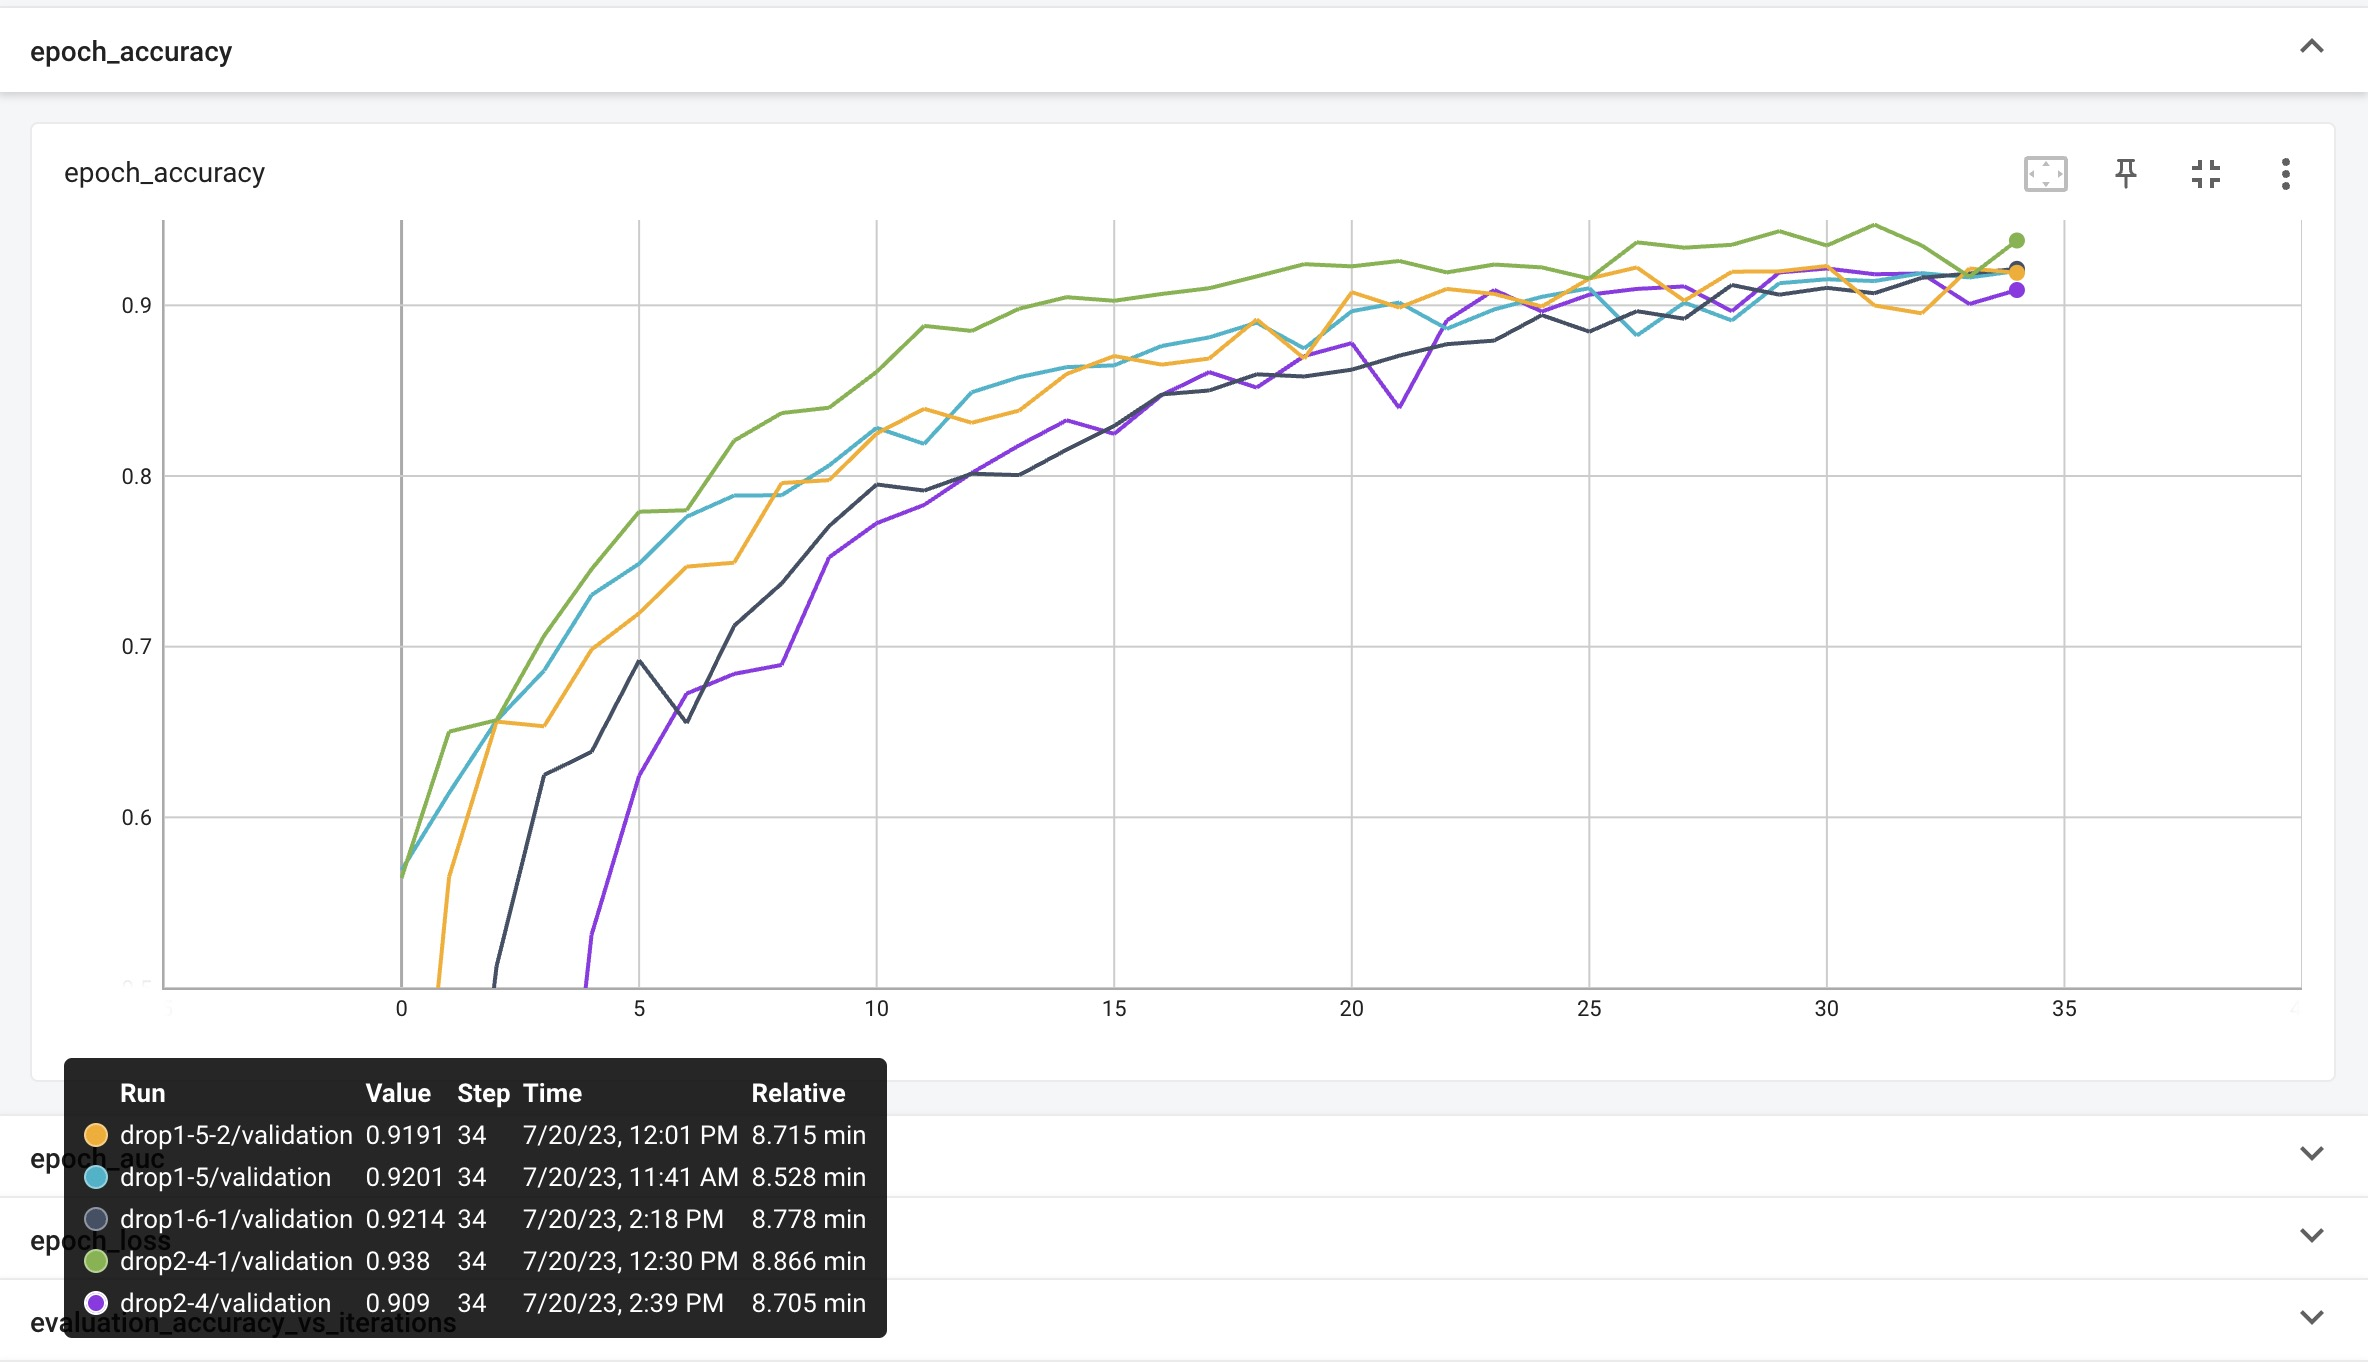

### When using TensorBoard to evalute the different dropout regularization methods we used, we can conclude that a dropout of 0.2 after the first maxpool and 0.4 after second maxpool and 0.1 after the flattening, works the best

### And compared to our v2 model we have a boost in accuracy about 3 points

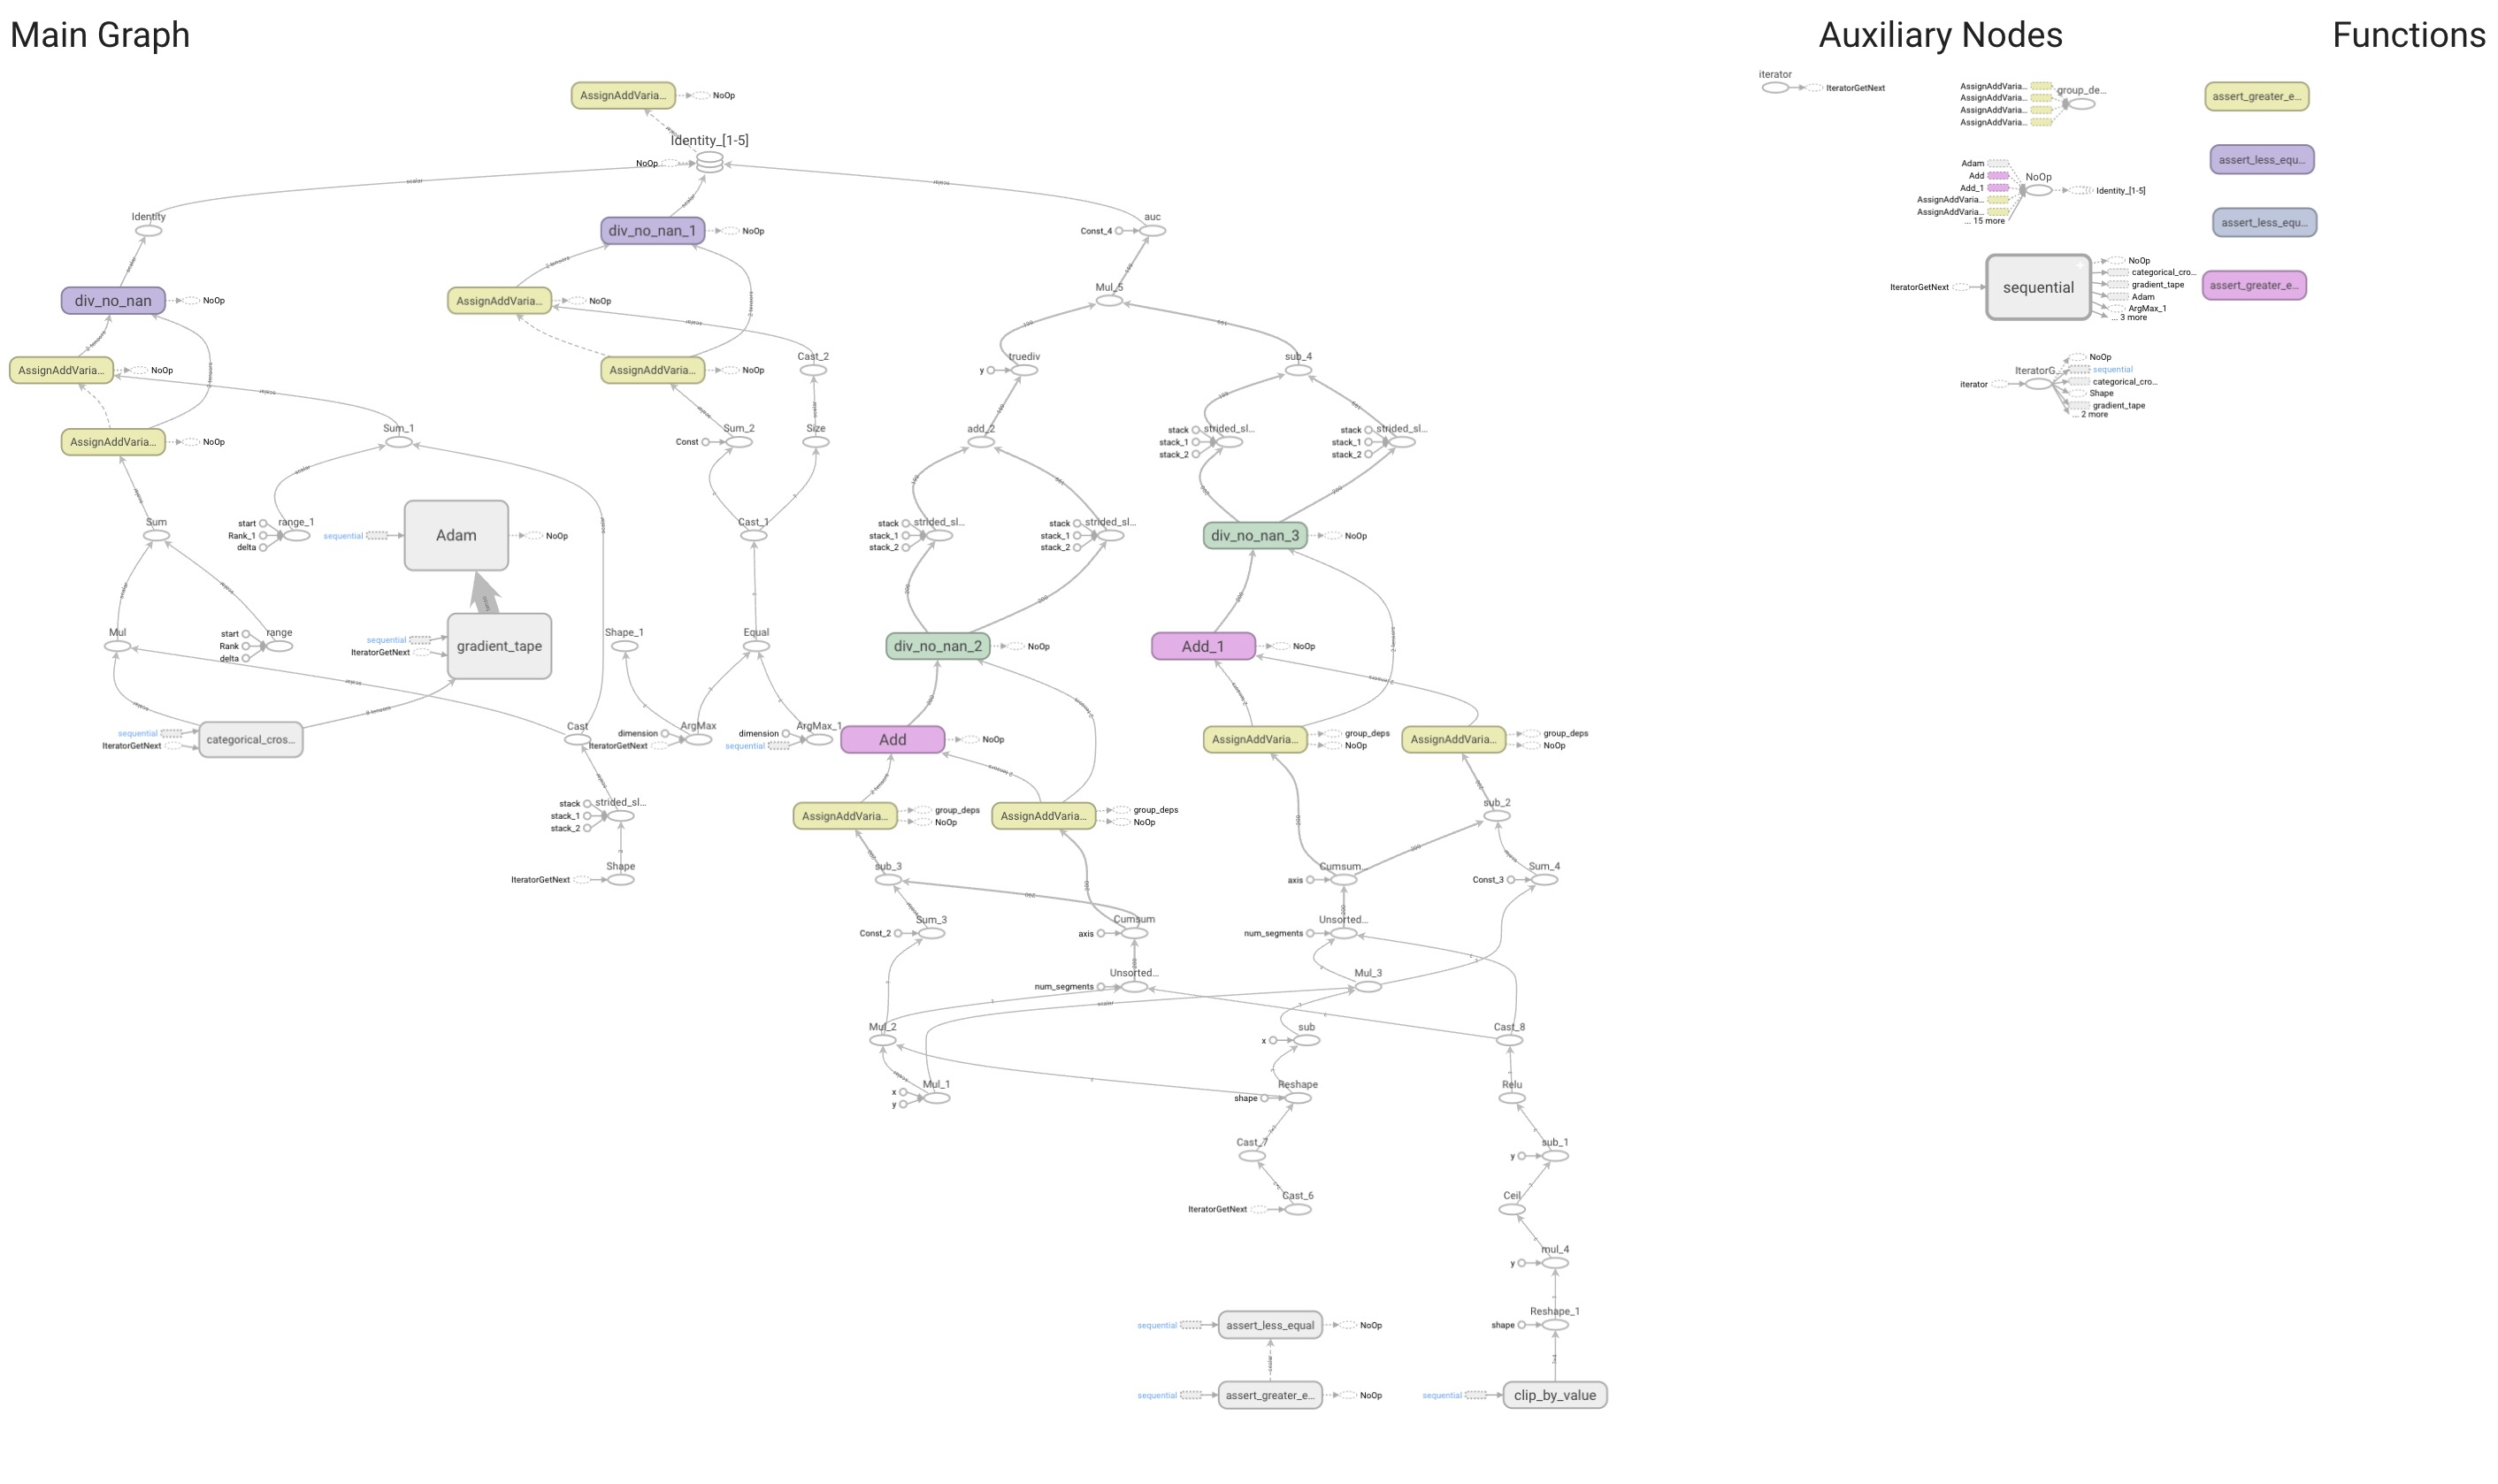

# Next step, Use a prebuilt Neural Network and tune it for a better model